# Indoor scene recognition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

np.random.seed(42)

## Load dataset

In [4]:
indoorCVPR = "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"

> A. Quattoni, and A.Torralba. Recognizing Indoor Scenes. IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2009.

In [11]:
!mkdir -p datasets
!wget {indoorCVPR} -O datasets/indoorCVPR_09.tar

--2020-02-15 04:17:15--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: 'datasets/indoorCVPR_09.tar'

datasets/indoorCVPR 100%[===================>]   2.41G  9.92MB/s    in 3m 33s  

2020-02-15 04:20:48 (11.6 MB/s) - 'datasets/indoorCVPR_09.tar' saved [2592010240/2592010240]



In [15]:
!tar -xf datasets/indoorCVPR_09.tar -C datasets/

In [16]:
datasets = Path("datasets/Images")

## View data

In [17]:
data = ImageDataBunch.from_folder(
    datasets,
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

In [18]:
data.c, data.classes, len(data.train_ds), len(data.valid_ds)

(67,
 ['airport_inside',
  'artstudio',
  'auditorium',
  'bakery',
  'bar',
  'bathroom',
  'bedroom',
  'bookstore',
  'bowling',
  'buffet',
  'casino',
  'children_room',
  'church_inside',
  'classroom',
  'cloister',
  'closet',
  'clothingstore',
  'computerroom',
  'concert_hall',
  'corridor',
  'deli',
  'dentaloffice',
  'dining_room',
  'elevator',
  'fastfood_restaurant',
  'florist',
  'gameroom',
  'garage',
  'greenhouse',
  'grocerystore',
  'gym',
  'hairsalon',
  'hospitalroom',
  'inside_bus',
  'inside_subway',
  'jewelleryshop',
  'kindergarden',
  'kitchen',
  'laboratorywet',
  'laundromat',
  'library',
  'livingroom',
  'lobby',
  'locker_room',
  'mall',
  'meeting_room',
  'movietheater',
  'museum',
  'nursery',
  'office',
  'operating_room',
  'pantry',
  'poolinside',
  'prisoncell',
  'restaurant',
  'restaurant_kitchen',
  'shoeshop',
  'stairscase',
  'studiomusic',
  'subway',
  'toystore',
  'trainstation',
  'tv_studio',
  'videostore',
  'waitingr

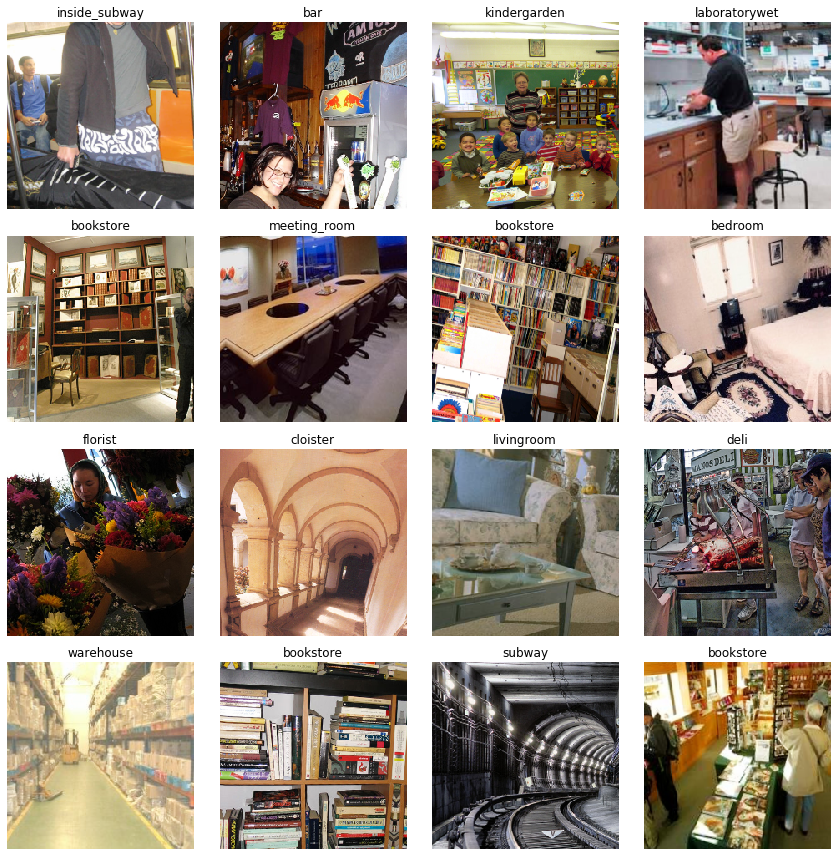

In [19]:
data.show_batch(rows=4, figsize=(12,12))

## Training: Resnet34

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


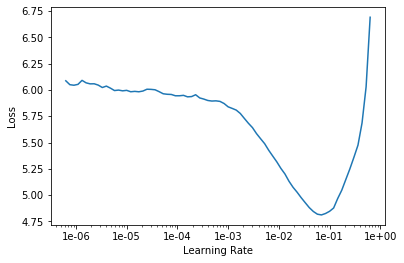

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.538255,1.504782,0.414853,01:35
1,1.631546,1.207174,0.343470,01:36
2,1.337174,1.063397,0.306978,01:35
3,1.115909,0.965748,0.278809,01:36
4,0.944214,0.957506,0.276248,01:36


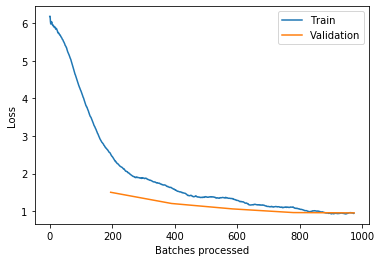

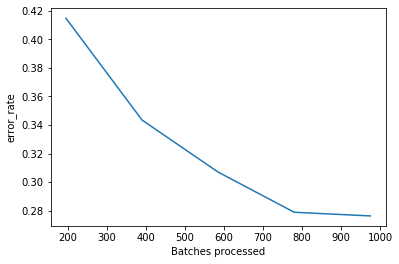

In [24]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [25]:
learn.save("stage-1")

## Training: ResNet34 unfreezing and fine-tuning

In [33]:
learn.load("stage-1")
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


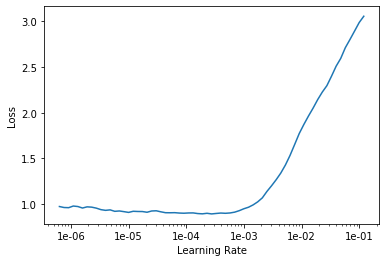

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.913080,0.907237,0.263764,02:12
1,0.804868,0.848279,0.250000,02:15
2,0.679861,0.839660,0.247759,02:14


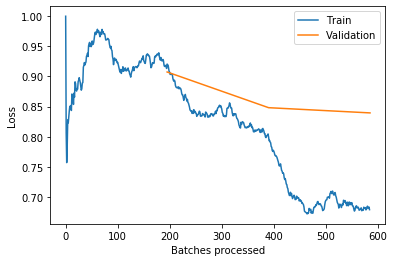

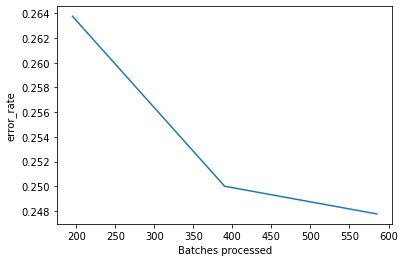

In [36]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [38]:
learn.save("stage-2")

## Interpretation

In [39]:
learn.load("stage-2")
interp = ClassificationInterpretation.from_learner(learn)

In [40]:
interp.most_confused(min_val=7)

[('bedroom', 'livingroom', 12),
 ('subway', 'airport_inside', 12),
 ('airport_inside', 'mall', 9),
 ('airport_inside', 'subway', 9),
 ('bakery', 'deli', 9),
 ('deli', 'bakery', 9),
 ('livingroom', 'bedroom', 9),
 ('movietheater', 'auditorium', 9),
 ('fastfood_restaurant', 'bar', 8),
 ('dining_room', 'livingroom', 7),
 ('library', 'bookstore', 7),
 ('restaurant', 'bar', 7)]

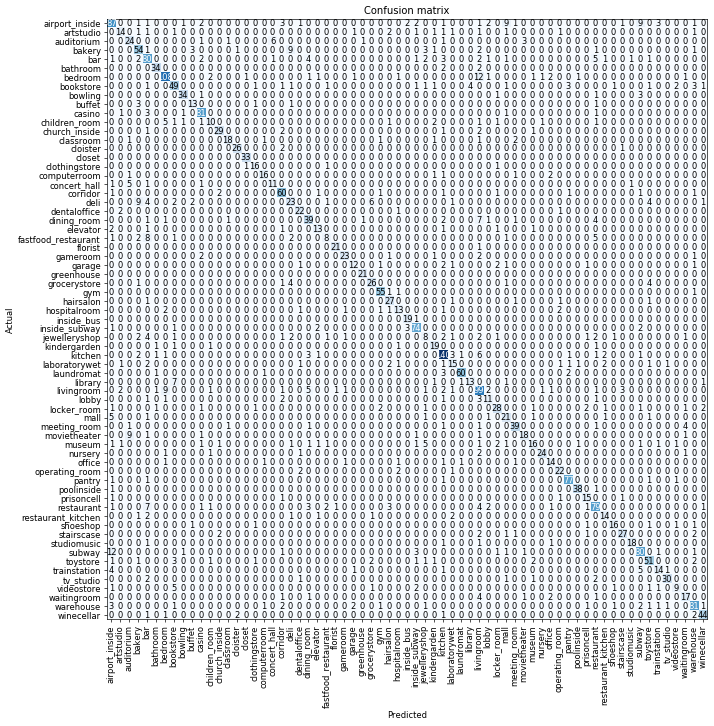

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

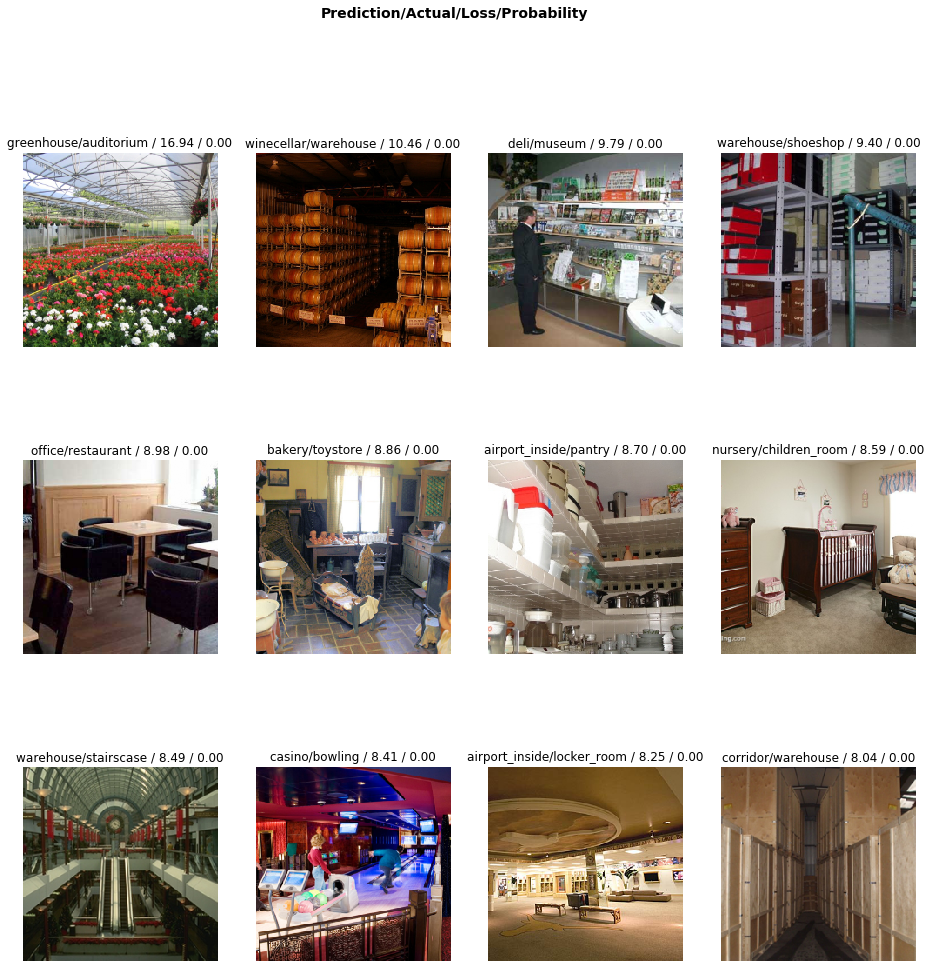

In [42]:
interp.plot_top_losses(12, figsize=(16,16))